In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm


ff1.Cache.enable_cache('2023Spain') 
fp = ff1.get_session(2023, 'Spain', 'FP2')
#fp_laps = fp.load_laps(with_telemetry=True)
fp.load()


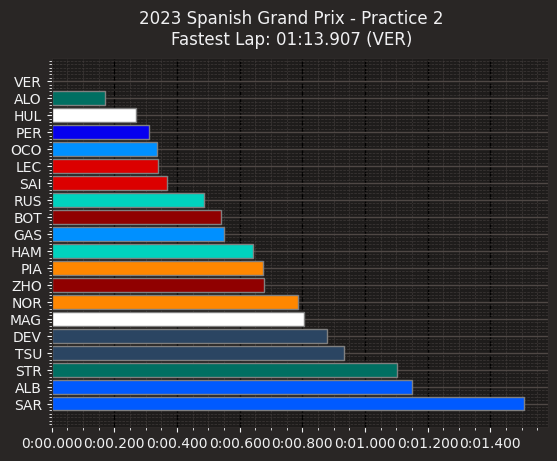

In [2]:
drivers = pd.unique(fp.laps['Driver'])
best_laps = list()
for driver in drivers:
    best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)
        
ff1.plotting.setup_mpl()
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

C:\Users\ricca\AppData\Local\Temp\ipykernel_18256\959840931.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merge = fastest_drv1.append(fastest_drv3)
C:\Users\ricca\AppData\Local\Temp\ipykernel_18256\959840931.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = merge.append(fastest_drv2)


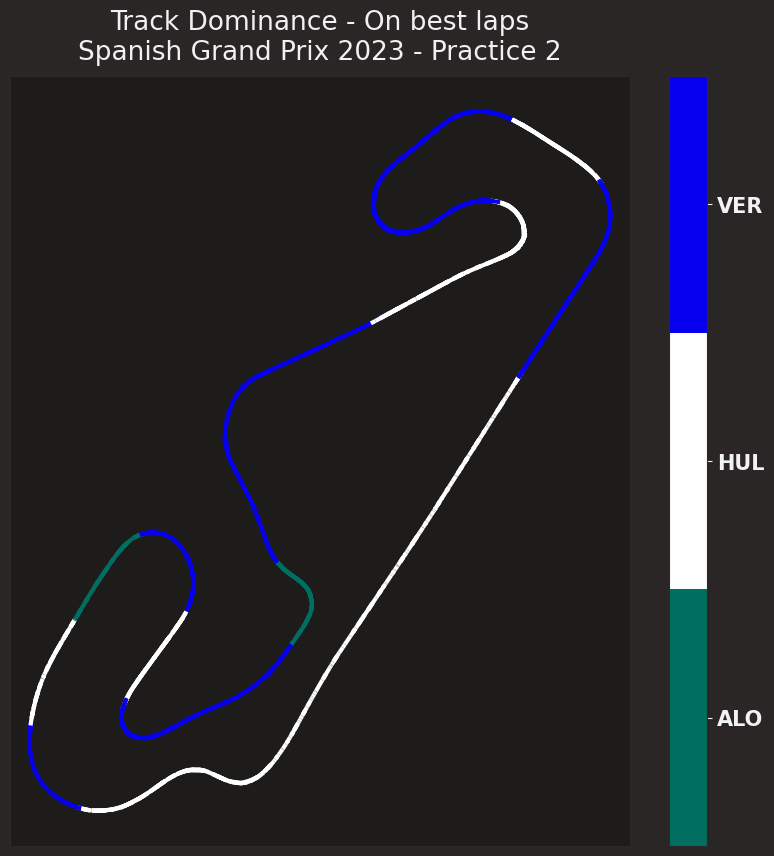

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()
fp_laps = fp.laps
driver1='ALO'
driver2='VER'
driver3='HUL'

color_drv1 = ff1.plotting.team_color('AMR')
color_drv2 = ff1.plotting.team_color('RBR')
color_drv3 = ff1.plotting.team_color('HAS')

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)
laps_drv3 = fp_laps.pick_driver(driver3)


fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()
fastest_drv3 = laps_drv3.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2
fastest_drv3['Driver'] = driver3

merge = fastest_drv1.append(fastest_drv3)
telemetry = merge.append(fastest_drv2)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver3, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 3


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv3, color_drv2])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(3)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,5))
cbar.set_ticks(np.arange(1.5, 4.5))
cbar.set_ticklabels([driver1, driver3, driver2], fontsize=15, fontweight = 'bold')

plt.show()

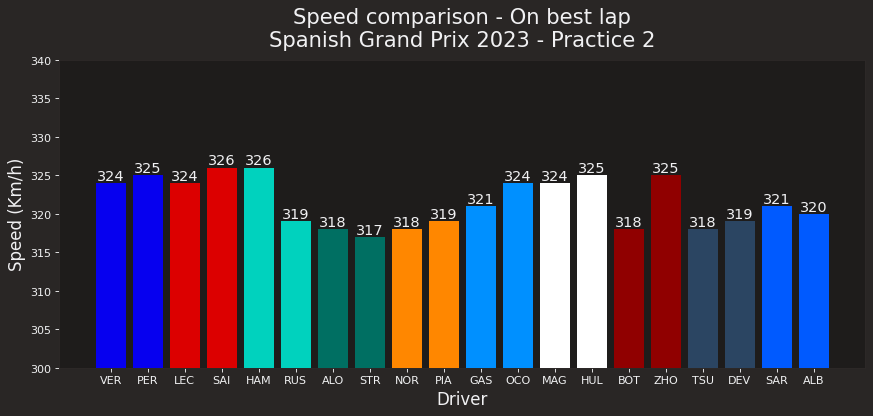

In [4]:
from collections import OrderedDict
fp_laps = fp.laps
#ricavo la lista di tutti i piloti
drivers = pd.unique(fp.laps['Driver'])
#elimino i tempi in cui i piloti erano in giro in o out
fp_laps = fp_laps.loc[(fp_laps['PitOutTime'].isnull() & fp_laps['PitInTime'].isnull() & fp_laps['IsAccurate'] == True)]

#dizionario dove inerirò tutte le massime velocità, le chiavi sono i nom dei piloti 
max_speed_dict = dict.fromkeys(drivers)

for driver in drivers:
        max_speed_dict[driver] = max(fp_laps.pick_driver(driver).pick_fastest().get_car_data()['Speed'])

team_color_drvrs = ['VER', 'PER', 'LEC', 'SAI', 'HAM', 'RUS', 'ALO', 'STR', 'NOR', 'PIA', 'GAS', 'OCO', 'MAG', 'HUL', 'BOT', 'ZHO', 'TSU', 'DEV', 'SAR', 'ALB']
team_colors = [ff1.plotting.team_color('RedBull'),ff1.plotting.team_color('RedBull'), 
               ff1.plotting.team_color('Ferrari'), ff1.plotting.team_color('Ferrari'),
               ff1.plotting.team_color('Mercedes'), ff1.plotting.team_color('Mercedes'),
               ff1.plotting.team_color('Aston Martin'), ff1.plotting.team_color('Aston Martin'),
               ff1.plotting.team_color('McLaren'), ff1.plotting.team_color('McLaren'),
               ff1.plotting.team_color('Alpine'), ff1.plotting.team_color('Alpine'),
               ff1.plotting.team_color('Haas'), ff1.plotting.team_color('Haas'),
               ff1.plotting.team_color('Alfa Romeo'), ff1.plotting.team_color('Alfa Romeo'),
               ff1.plotting.team_color('Alpha Tauri'), ff1.plotting.team_color('Alpha Tauri'),
               ff1.plotting.team_color('Williams'), ff1.plotting.team_color('Williams'),]

max_speed_dict_ordered = OrderedDict((k, max_speed_dict[k]) for k in team_color_drvrs)
max_speed_dict_ordered = dict(max_speed_dict_ordered)

ff1.plotting.setup_mpl()
figure(figsize=(13, 5), dpi=80)
plt.bar_label(plt.bar(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.values()), align='center', color=team_colors), fontsize = 13)
plt.xticks(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.keys()))

ax = plt.gca()
ax.set_ylim([300, 340])
plt.title(f"Speed comparison - On best lap\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")

plt.xlabel('Driver', fontsize=15)
plt.ylabel('Speed (Km/h)', fontsize=15)
plt.show()

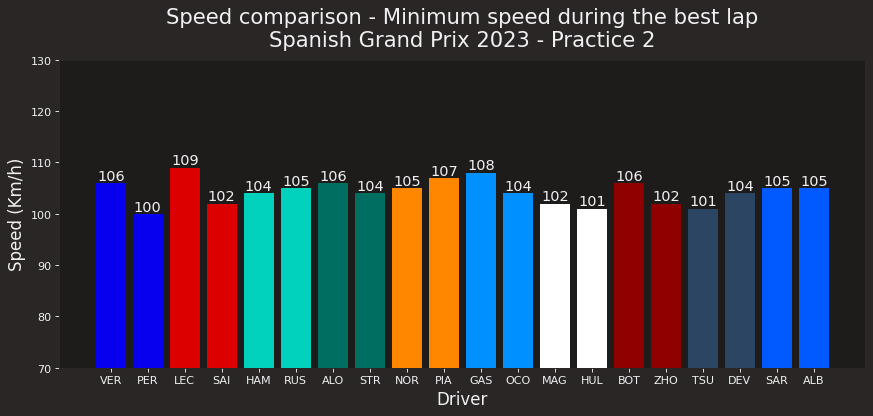

In [5]:
from collections import OrderedDict

#ricavo la lista di tutti i piloti
drivers = pd.unique(fp.laps['Driver'])
#elimino i tempi in cui i piloti erano in giro in o out
fp_laps = fp.laps.loc[(fp.laps['PitOutTime'].isnull() & fp.laps['PitInTime'].isnull() & fp.laps['IsAccurate'] == True)]

#dizionario dove inerirò tutte le massime velocità, le chiavi sono i nom dei piloti 
max_speed_dict = dict.fromkeys(drivers)

for driver in drivers:
        max_speed_dict[driver] = min(fp_laps.pick_driver(driver).pick_fastest().get_car_data()['Speed'])

team_color_drvrs = ['VER', 'PER', 'LEC', 'SAI', 'HAM', 'RUS', 'ALO', 'STR', 'NOR', 'PIA', 'GAS', 'OCO', 'MAG', 'HUL', 'BOT', 'ZHO', 'TSU', 'DEV', 'SAR', 'ALB']
team_colors = [ff1.plotting.team_color('RedBull'),ff1.plotting.team_color('RedBull'), 
               ff1.plotting.team_color('Ferrari'), ff1.plotting.team_color('Ferrari'),
               ff1.plotting.team_color('Mercedes'), ff1.plotting.team_color('Mercedes'),
               ff1.plotting.team_color('Aston Martin'), ff1.plotting.team_color('Aston Martin'),
               ff1.plotting.team_color('McLaren'), ff1.plotting.team_color('McLaren'),
               ff1.plotting.team_color('Alpine'), ff1.plotting.team_color('Alpine'),
               ff1.plotting.team_color('Haas'), ff1.plotting.team_color('Haas'),
               ff1.plotting.team_color('Alfa Romeo'), ff1.plotting.team_color('Alfa Romeo'),
               ff1.plotting.team_color('Alpha Tauri'), ff1.plotting.team_color('Alpha Tauri'),
               ff1.plotting.team_color('Williams'), ff1.plotting.team_color('Williams'),]

max_speed_dict_ordered = OrderedDict((k, max_speed_dict[k]) for k in team_color_drvrs)
max_speed_dict_ordered = dict(max_speed_dict_ordered)

ff1.plotting.setup_mpl()

figure(figsize=(13, 5), dpi=80)
plt.bar_label(plt.bar(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.values()), align='center', color=team_colors), fontsize = 13)
plt.xticks(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.keys()))

ax = plt.gca()
ax.set_ylim([70, 130])
plt.title(f"Speed comparison - Minimum speed during the best lap\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")

plt.xlabel('Driver', fontsize=15)
plt.ylabel('Speed (Km/h)', fontsize=15)
plt.show()

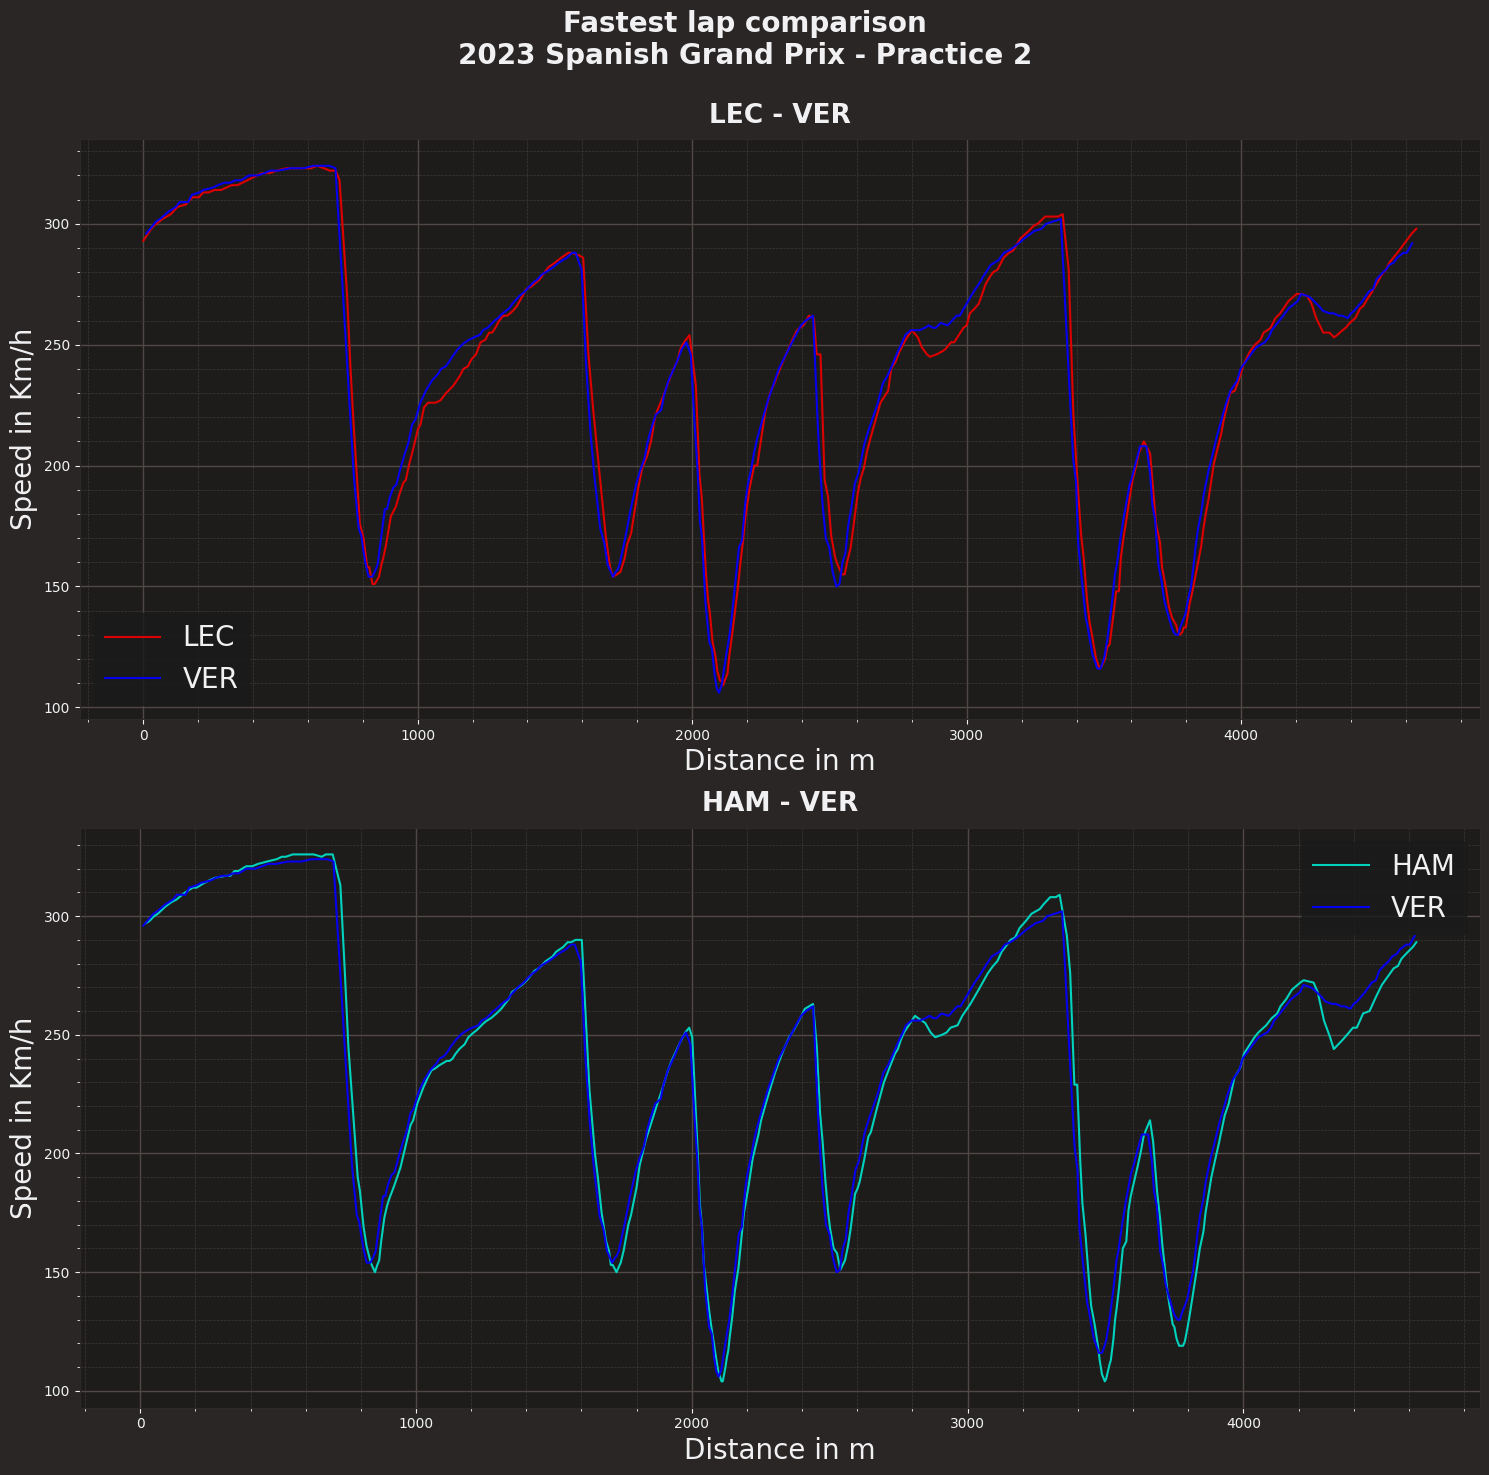

In [6]:
import matplotlib.pyplot as plt
import fastf1.plotting

ff1.plotting.setup_mpl()

lec_lap = fp.laps.pick_driver('LEC').pick_fastest()
ver_lap = fp.laps.pick_driver('VER').pick_fastest()
alo_lap = fp.laps.pick_driver('HAM').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()
ver_tel = ver_lap.get_car_data().add_distance()
alo_tel = alo_lap.get_car_data().add_distance()

ferr_color = ff1.plotting.team_color('FER')
rbr_color = ff1.plotting.team_color('RBR')
aston_color = ff1.plotting.team_color('MER')

fig1, ax1 = plt.subplots(2)
fig1.set_figheight(15)
fig1.set_figwidth(15)
ax1[0].plot(lec_tel['Distance'], lec_tel['Speed'], color = ferr_color, label = 'LEC')
ax1[0].plot(ver_tel['Distance'], ver_tel['Speed'], color = rbr_color, label = 'VER')

ax1[0].set_xlabel('Distance in m', size=20)
ax1[0].set_ylabel('Speed in Km/h', size=20)

ax1[0].legend(prop={'size': 20})
ax1[0].set_title(f"{lec_lap['Driver']} - {ver_lap['Driver']}", fontweight = "bold", ha='center')


ax1[1].plot(alo_tel['Distance'], alo_tel['Speed'], color = aston_color, label = 'HAM')
ax1[1].plot(ver_tel['Distance'], ver_tel['Speed'], color = rbr_color, label = 'VER')

ax1[1].set_xlabel('Distance in m', size=20)
ax1[1].set_ylabel('Speed in Km/h', size=20)

ax1[1].legend(prop={'size': 20})
ax1[1].set_title(f"{alo_lap['Driver']} - {ver_lap['Driver']}", fontweight = "bold", ha='center')

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n", size = 20, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()


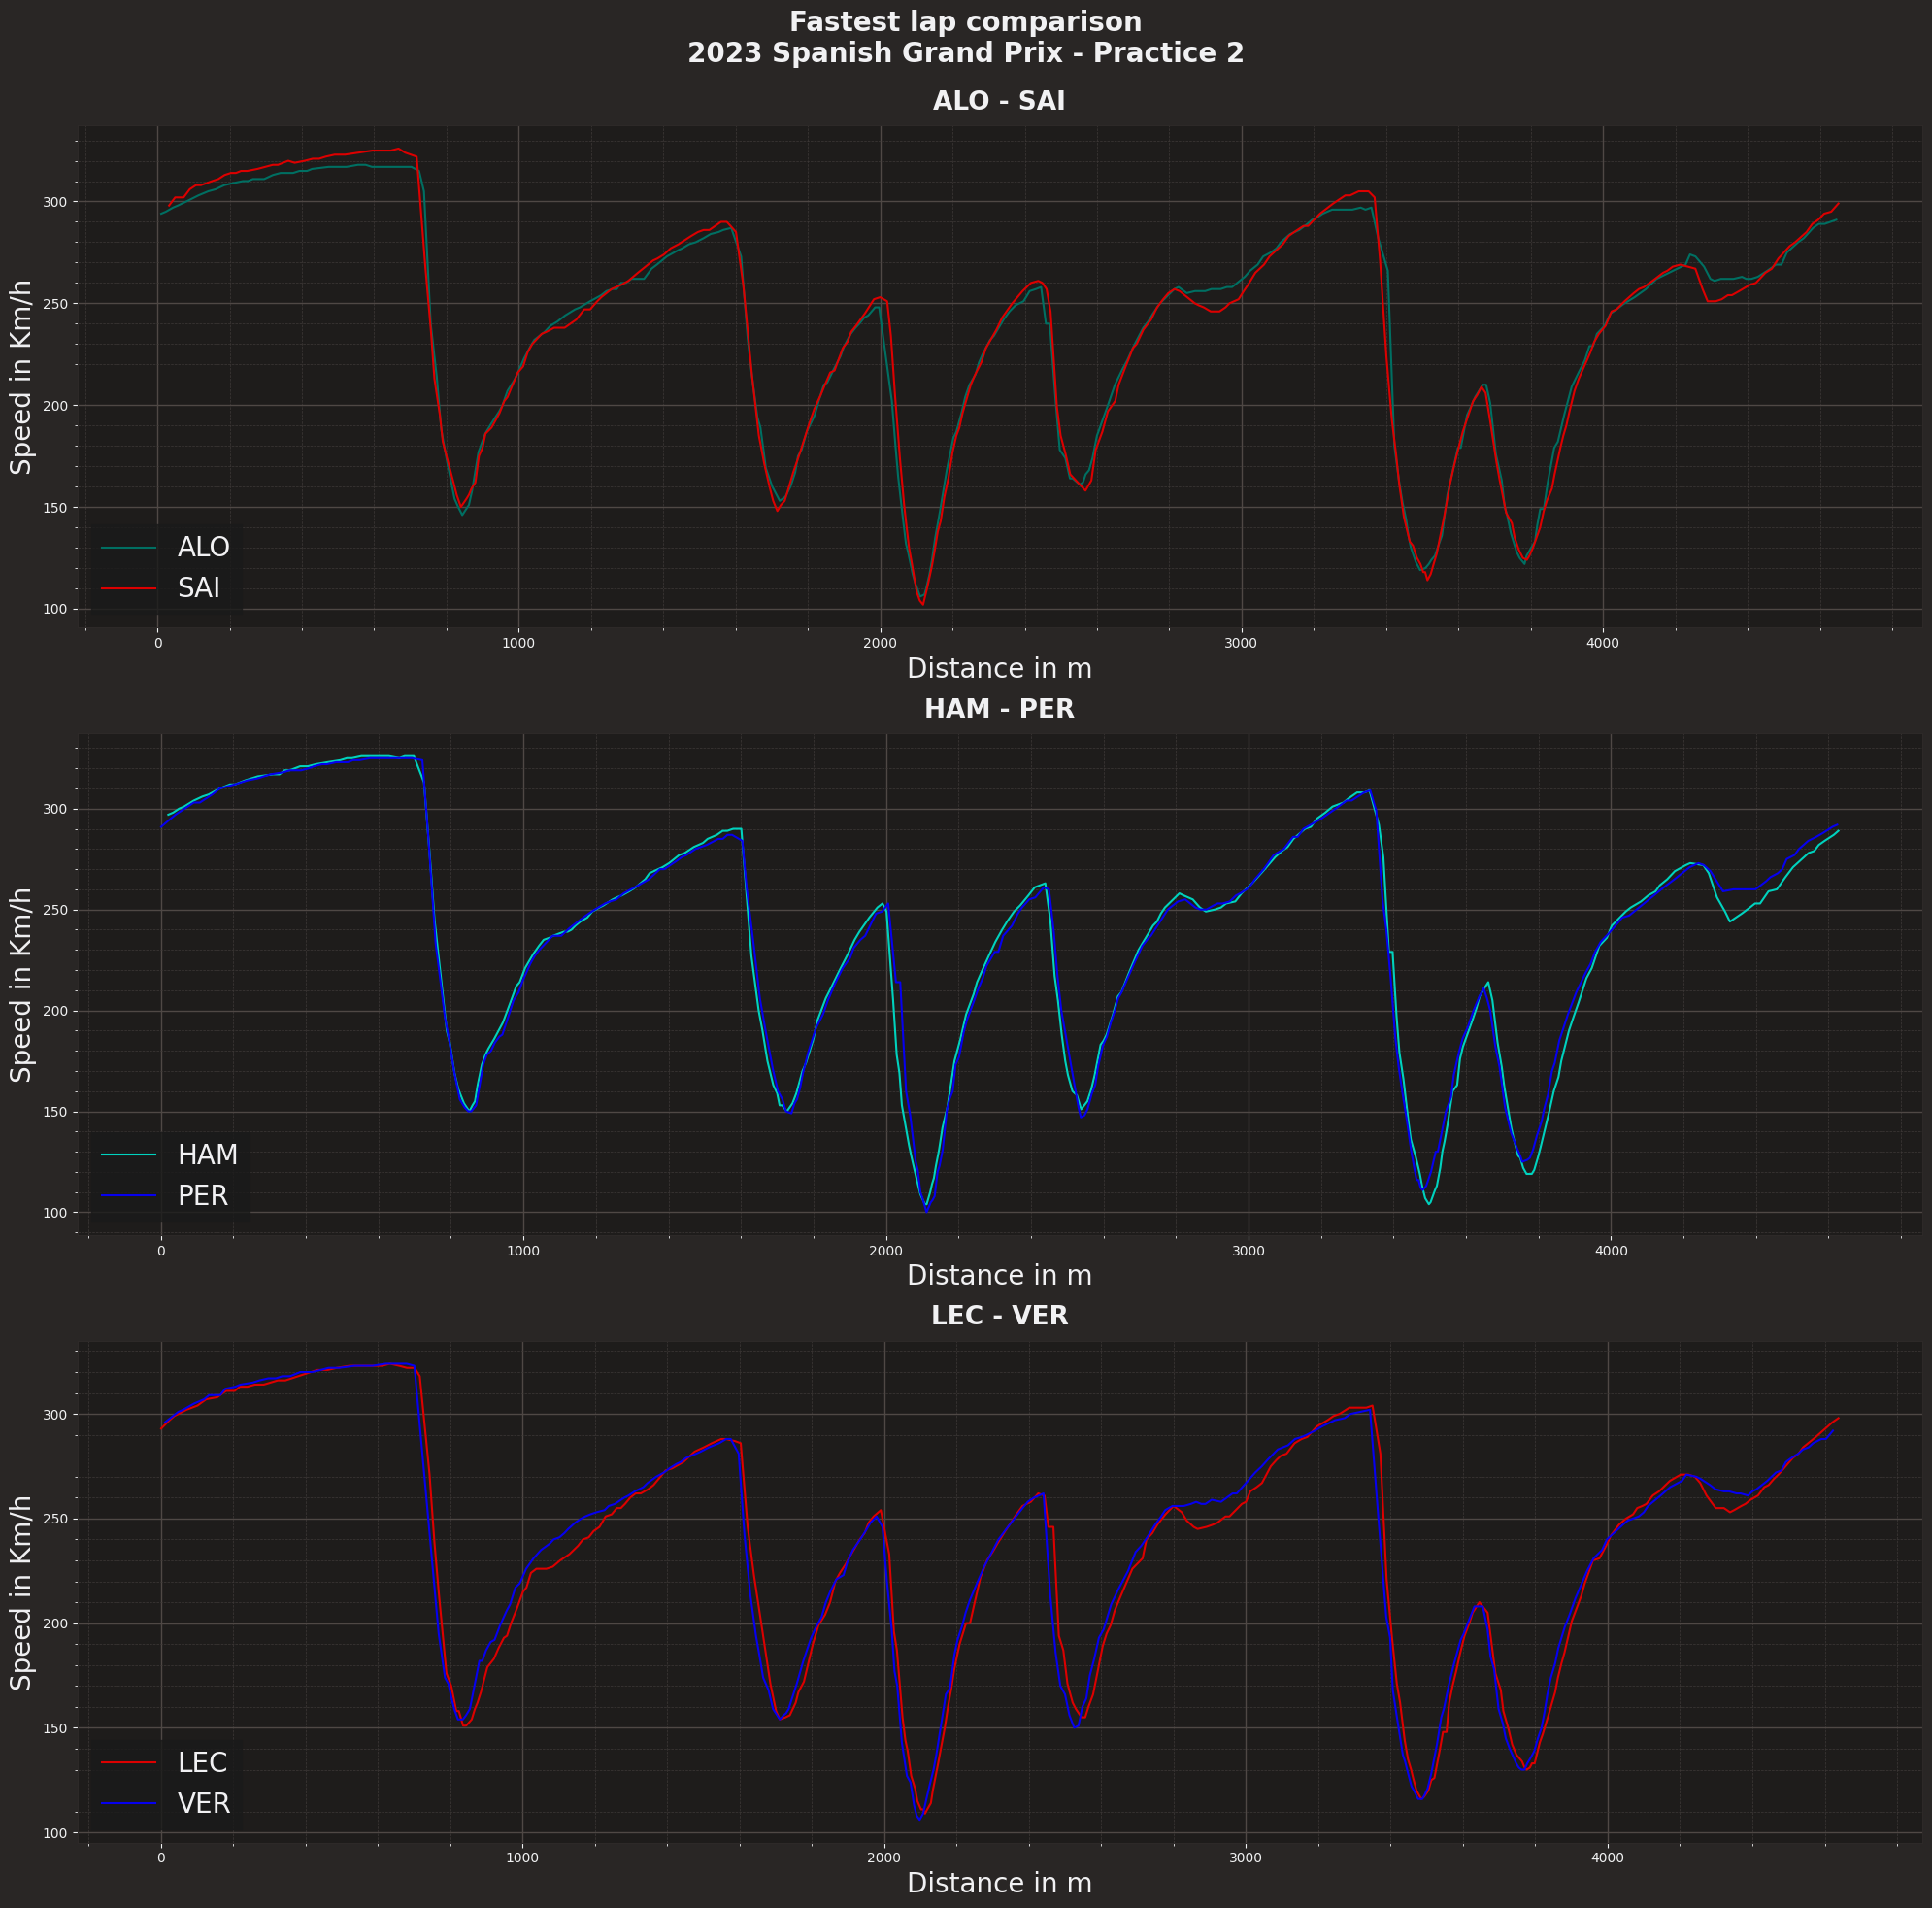

In [7]:
import matplotlib.pyplot as plt
import fastf1.plotting

ff1.plotting.setup_mpl()

lec_lap = fp.laps.pick_driver('LEC').pick_fastest()
ver_lap = fp.laps.pick_driver('VER').pick_fastest()
sai_lap = fp.laps.pick_driver('SAI').pick_fastest()
per_lap = fp.laps.pick_driver('PER').pick_fastest()
ham_lap = fp.laps.pick_driver('HAM').pick_fastest()
rus_lap = fp.laps.pick_driver('RUS').pick_fastest()
alo_lap = fp.laps.pick_driver('ALO').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()
ver_tel = ver_lap.get_car_data().add_distance()
sai_tel = sai_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()
rus_tel = rus_lap.get_car_data().add_distance()
alo_tel = alo_lap.get_car_data().add_distance()

ferr_color = ff1.plotting.team_color('FER')
rbr_color = ff1.plotting.team_color('RBR')
mer_color = ff1.plotting.team_color('MER')
aston_color = ff1.plotting.team_color('AMR')

fig1, ax1 = plt.subplots(3)
fig1.set_figheight(20)
fig1.set_figwidth(20)
ax1[0].plot(alo_tel['Distance'], alo_tel['Speed'], color = aston_color, label = 'ALO')
ax1[0].plot(sai_tel['Distance'], sai_tel['Speed'], color = ferr_color, label = 'SAI')

ax1[0].set_xlabel('Distance in m', size=20)
ax1[0].set_ylabel('Speed in Km/h', size=20)

ax1[0].legend(prop={'size': 20})
ax1[0].set_title(f"{alo_lap['Driver']} - {sai_lap['Driver']}", fontweight = "bold", ha='center')


ax1[1].plot(ham_tel['Distance'], ham_tel['Speed'], color = mer_color, label = 'HAM')
ax1[1].plot(per_tel['Distance'], per_tel['Speed'], color = rbr_color, label = 'PER')

ax1[1].set_xlabel('Distance in m', size=20)
ax1[1].set_ylabel('Speed in Km/h', size=20)

ax1[1].legend(prop={'size': 20})
ax1[1].set_title(f"{ham_lap['Driver']} - {per_lap['Driver']}", fontweight = "bold", ha='center')

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event['EventName']} {fp.event.year}\n", size = 20, weight='bold', ha='center')



ax1[2].plot(lec_tel['Distance'], lec_tel['Speed'], color = ferr_color, label = 'LEC')
ax1[2].plot(ver_tel['Distance'],ver_tel['Speed'], color = rbr_color, label = 'VER')

ax1[2].set_xlabel('Distance in m', size=20)
ax1[2].set_ylabel('Speed in Km/h', size=20)

ax1[2].legend(prop={'size': 20})
ax1[2].set_title(f"{lec_lap['Driver']} - {ver_lap['Driver']}", fontweight = "bold", ha='center')

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n", size = 20, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()


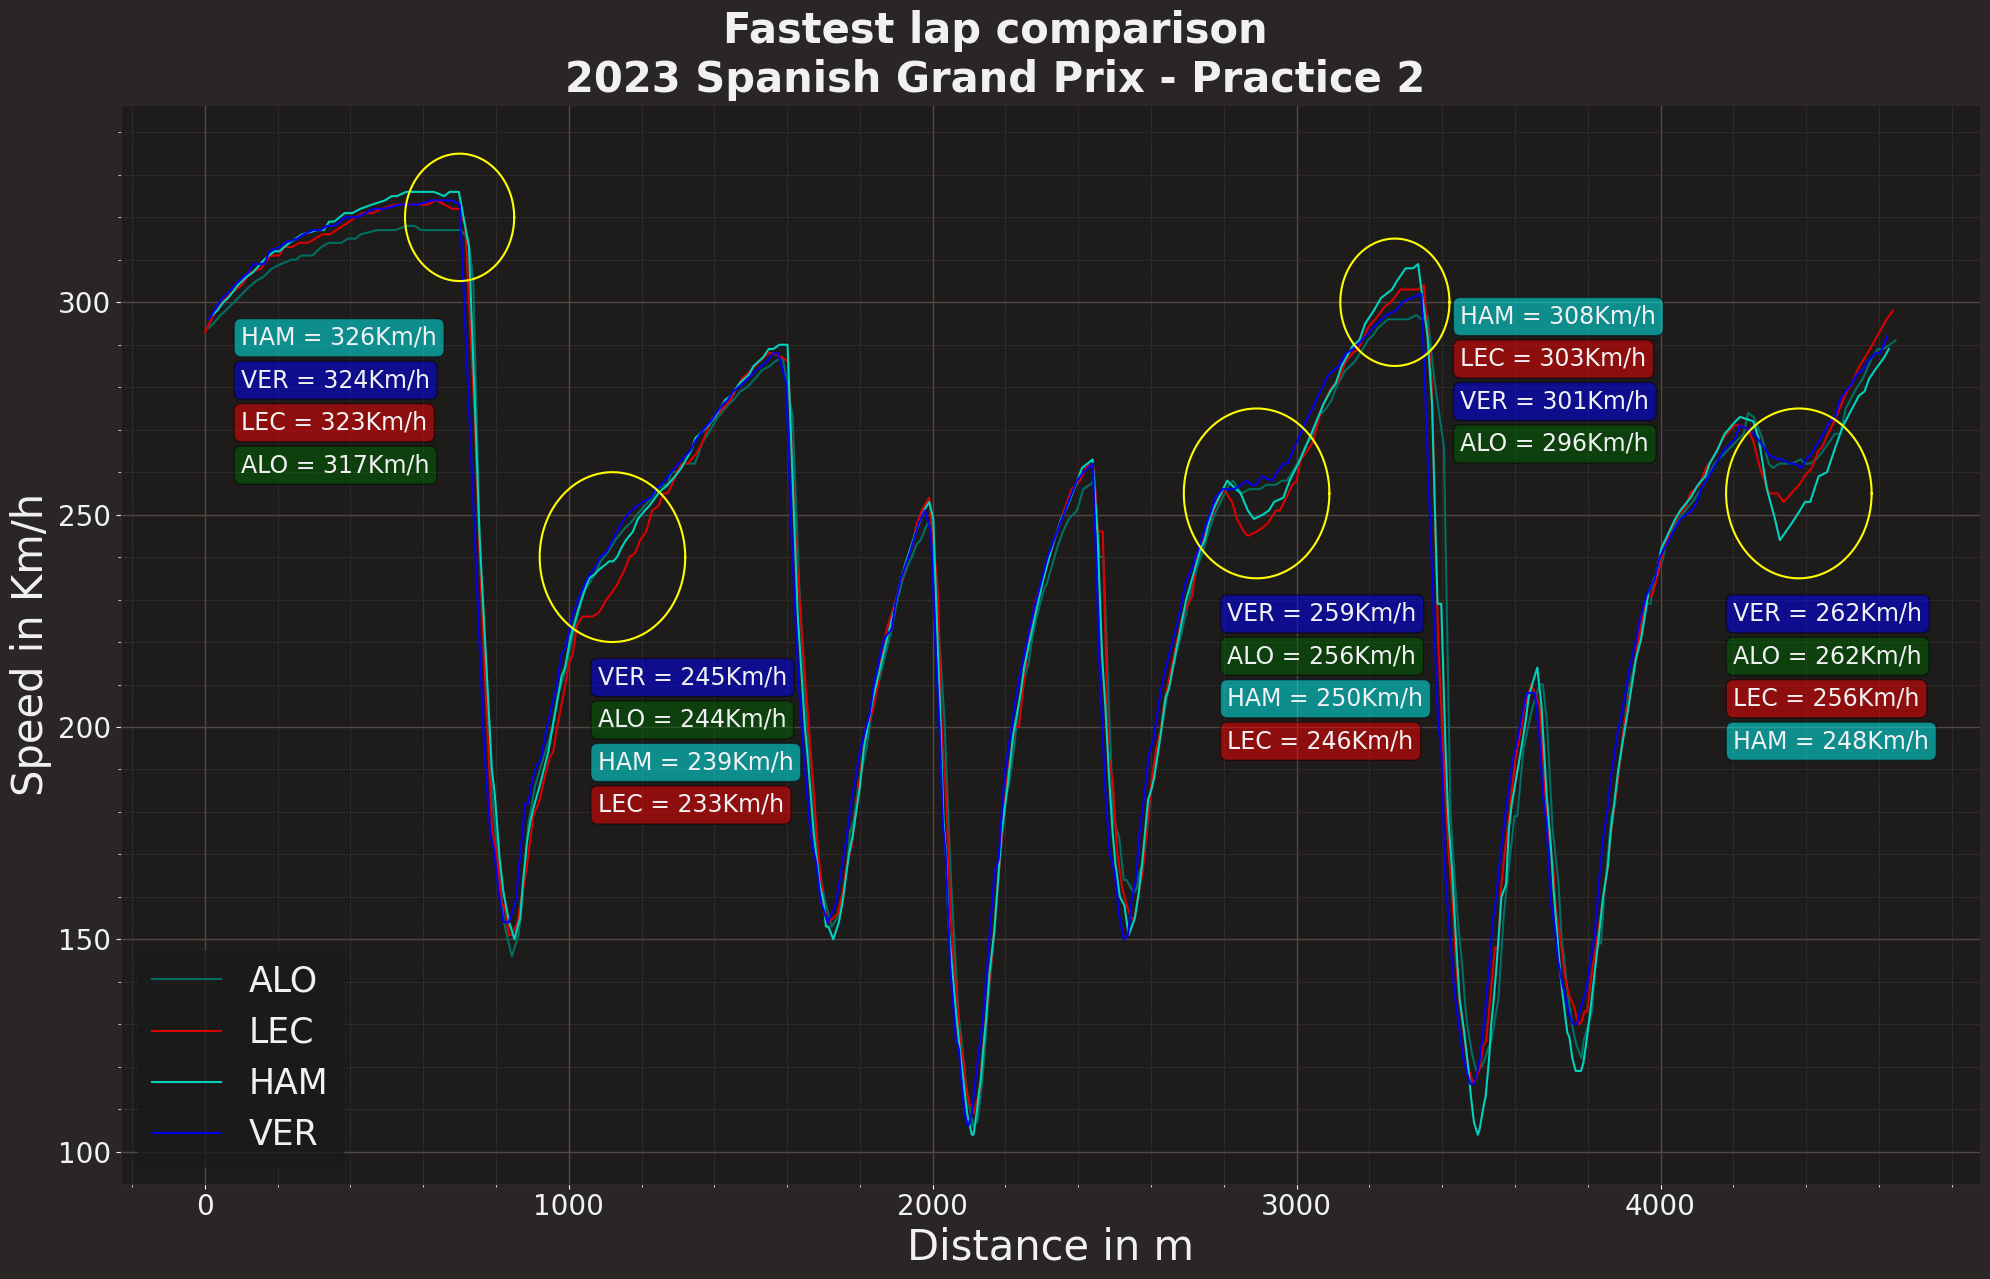

In [8]:
import matplotlib.pyplot as plt
import fastf1.plotting
from math import pi
ff1.plotting.setup_mpl()

lec_lap = fp.laps.pick_driver('LEC').pick_fastest()
ver_lap = fp.laps.pick_driver('VER').pick_fastest()
sai_lap = fp.laps.pick_driver('SAI').pick_fastest()
per_lap = fp.laps.pick_driver('PER').pick_fastest()
ham_lap = fp.laps.pick_driver('HAM').pick_fastest()
rus_lap = fp.laps.pick_driver('RUS').pick_fastest()
alo_lap = fp.laps.pick_driver('ALO').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()
ver_tel = ver_lap.get_car_data().add_distance()
sai_tel = sai_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()
rus_tel = rus_lap.get_car_data().add_distance()
alo_tel = alo_lap.get_car_data().add_distance()

ferr_color = ff1.plotting.team_color('FER')
rbr_color = ff1.plotting.team_color('RBR')
mer_color = ff1.plotting.team_color('MER')
aston_color = ff1.plotting.team_color('AMR')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(13)
fig1.set_figwidth(20)
ax1.plot(alo_tel['Distance'], alo_tel['Speed'], color = aston_color, label = 'ALO')
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = ferr_color, label = 'LEC')
ax1.plot(ham_tel['Distance'], ham_tel['Speed'], color = mer_color, label = 'HAM')
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = rbr_color, label = 'VER')


ax1.set_xlabel('Distance in m', size=30)
ax1.set_ylabel('Speed in Km/h', size=30)
ax1.tick_params(labelsize=20)
ax1.legend(prop={'size': 25})

u=1120     #x-position of the center
v=240    #y-position of the center
a=200    #radius on the x-axis
b=20    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1.plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow")

ver_tel_speed = ver_tel.query('Distance >= 1120')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 1120')['Speed'].iloc[0]
alo_tel_speed = alo_tel.query('Distance >= 1120')['Speed'].iloc[0]
ham_tel_speed = ham_tel.query('Distance >= 1120')['Speed'].iloc[0]

ax1.text(x=1080, y = 180, s = "LEC = " + str(lec_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(x=1080, y = 210, s = "VER = " + str(ver_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax1.text(x=1080, y = 200, s = "ALO = " + str(alo_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.5))
ax1.text(x=1080, y = 190, s = "HAM = " + str(ham_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='aqua', alpha=0.5))

u=2890     #x-position of the center
v=255    #y-position of the center
a=200    #radius on the x-axis
b=20    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1.plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow")

ver_tel_speed = ver_tel.query('Distance >= 2890')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 2890')['Speed'].iloc[0]
alo_tel_speed = alo_tel.query('Distance >= 2890')['Speed'].iloc[0]
ham_tel_speed = ham_tel.query('Distance >= 2890')['Speed'].iloc[0]

ax1.text(x=2810, y = 195, s = "LEC = " + str(lec_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(x=2810, y = 225, s = "VER = " + str(ver_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax1.text(x=2810, y = 215, s = "ALO = " + str(alo_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.5))
ax1.text(x=2810, y = 205, s = "HAM = " + str(ham_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='aqua', alpha=0.5))

u=4380     #x-position of the center
v=255    #y-position of the center
a=200    #radius on the x-axis
b=20    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1.plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow")

ver_tel_speed = ver_tel.query('Distance >= 4350')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 4350')['Speed'].iloc[0]
alo_tel_speed = alo_tel.query('Distance >= 4350')['Speed'].iloc[0]
ham_tel_speed = ham_tel.query('Distance >= 4350')['Speed'].iloc[0]

ax1.text(x=4200, y = 205, s = "LEC = " + str(lec_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(x=4200, y = 225, s = "VER = " + str(ver_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax1.text(x=4200, y = 215, s = "ALO = " + str(alo_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.5))
ax1.text(x=4200, y = 195, s = "HAM = " + str(ham_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='aqua', alpha=0.5))



u=700     #x-position of the center
v=320    #y-position of the center
a=150    #radius on the x-axis
b=15    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1.plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow")

ver_tel_speed = ver_tel.query('Distance >= 600')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 600')['Speed'].iloc[0]
alo_tel_speed = alo_tel.query('Distance >= 600')['Speed'].iloc[0]
ham_tel_speed = ham_tel.query('Distance >= 600')['Speed'].iloc[0]

ax1.text(x=100, y = 270, s = "LEC = " + str(lec_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(x=100, y = 280, s = "VER = " + str(ver_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax1.text(x=100, y = 260, s = "ALO = " + str(alo_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.5))
ax1.text(x=100, y = 290, s = "HAM = " + str(ham_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='aqua', alpha=0.5))


u=3270     #x-position of the center
v=300    #y-position of the center
a=150    #radius on the x-axis
b=15    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1.plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow")

ver_tel_speed = ver_tel.query('Distance >= 3300')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 3300')['Speed'].iloc[0]
alo_tel_speed = alo_tel.query('Distance >= 3300')['Speed'].iloc[0]
ham_tel_speed = ham_tel.query('Distance >= 3300')['Speed'].iloc[0]

ax1.text(x=3450, y = 285, s = "LEC = " + str(lec_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
ax1.text(x=3450, y = 275, s = "VER = " + str(ver_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax1.text(x=3450, y = 265, s = "ALO = " + str(alo_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.5))
ax1.text(x=3450, y = 295, s = "HAM = " + str(ham_tel_speed) +"Km/h", fontsize=17, bbox=dict(boxstyle='round', facecolor='aqua', alpha=0.5))


fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}", size = 30, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()
